In [15]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col,avg
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
import pyspark

In [16]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

## Load Average Profile csv

In [17]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)
#avg_power_df = sqlcontext.read.format("com.databricks.spark.csv").load(base_path+"avg.csv/*")#csv(base_path+"avg.csv/",header=True,inferSchema=True)
avg_power_df = sqlcontext.read.csv(base_path+"avg.csv",header=True,inferSchema=True).cache()
avg_power_df.count()

3930

## Adding "`" to properly  select OW Analysis exception

### just to be clear, the reason for this is that the column name has a period in it. Spark is in general a little buggy as far as properly supporting backticks throughout codebase, but in this case they're fine

In [18]:
avg_power_df = avg_power_df.drop("_c0")
avg_power_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 00.5: double (nullable = true)
 |-- 01.0: double (nullable = true)
 |-- 01.5: double (nullable = true)
 |-- 02.0: double (nullable = true)
 |-- 02.5: double (nullable = true)
 |-- 03.0: double (nullable = true)
 |-- 03.5: double (nullable = true)
 |-- 04.0: double (nullable = true)
 |-- 04.5: double (nullable = true)
 |-- 05.0: double (nullable = true)
 |-- 05.5: double (nullable = true)
 |-- 06.0: double (nullable = true)
 |-- 06.5: double (nullable = true)
 |-- 07.0: double (nullable = true)
 |-- 07.5: double (nullable = true)
 |-- 08.0: double (nullable = true)
 |-- 08.5: double (nullable = true)
 |-- 09.0: double (nullable = true)
 |-- 09.5: double (nullable = true)
 |-- 10.0: double (nullable = true)
 |-- 10.5: double (nullable = true)
 |-- 11.0: double (nullable = true)
 |-- 11.5: double (nullable = true)
 |-- 12.0: double (nullable = true)
 |-- 12.5: double (nullable = true)
 |-- 13.0: double (nullable = true)
 |-- 13.5: double (nul

In [19]:
old_Feature_cols = []
new_Feature_cols = []
for i in range(1,49):
    if i<20:
        old_Feature_cols.append("0"+str(i*0.5))
    else:
        old_Feature_cols.append(str(i*0.5))
    if i<10:
        new_Feature_cols.append("0"+str(i))
    else:
        new_Feature_cols.append(str(i))
        
for c,n in zip(old_Feature_cols,new_Feature_cols):
            avg_power_df=avg_power_df.withColumnRenamed(c,n)

for i in range(1,len(new_Feature_cols),2):
    avg_power_df = avg_power_df.withColumn(new_Feature_cols[i],avg_power_df[new_Feature_cols[i-1]]+avg_power_df[new_Feature_cols[i]])
    avg_power_df = avg_power_df.drop(new_Feature_cols[i-1])
for i in range(24):
    avg_power_df = avg_power_df.withColumnRenamed(new_Feature_cols[2*i+1],new_Feature_cols[i])
avg_power_df.printSchema()
avg_power_df.take(1)
    

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)



[Row(LCLid='MAC000439', 01=0.7359276312500002, 02=0.5229605263157896, 03=0.3533651315789472, 04=0.24809539473684195, 05=0.21901315789473685, 06=0.21294407894736847, 07=0.231875, 08=0.2783552628289474, 09=0.2887927631578948, 10=0.32406907894736814, 11=0.4843026315789474, 12=0.6056973694078949, 13=0.508345396381579, 14=0.6762434184210528, 15=0.5515032898026317, 16=0.34423355197368416, 17=0.35018421052631576, 18=0.47835855263157906, 19=0.5845822371710525, 20=0.6602302631578948, 21=0.698687500328947, 22=0.7542796052631577, 23=1.0284934230263154, 24=0.9880427644736851)]

###### TODO : Scaling Feature using MinMaxSacler or any other can be done

In [20]:
avg_house_data = avg_power_df
new_Feature_cols = new_Feature_cols[0:24]
vecAssembler = VectorAssembler(inputCols=new_Feature_cols, outputCol="features")
df_kmeans = vecAssembler.transform(avg_power_df)
df_kmeans.take(1)

[Row(LCLid='MAC000439', 01=0.7359276312500002, 02=0.5229605263157896, 03=0.3533651315789472, 04=0.24809539473684195, 05=0.21901315789473685, 06=0.21294407894736847, 07=0.231875, 08=0.2783552628289474, 09=0.2887927631578948, 10=0.32406907894736814, 11=0.4843026315789474, 12=0.6056973694078949, 13=0.508345396381579, 14=0.6762434184210528, 15=0.5515032898026317, 16=0.34423355197368416, 17=0.35018421052631576, 18=0.47835855263157906, 19=0.5845822371710525, 20=0.6602302631578948, 21=0.698687500328947, 22=0.7542796052631577, 23=1.0284934230263154, 24=0.9880427644736851, features=DenseVector([0.7359, 0.523, 0.3534, 0.2481, 0.219, 0.2129, 0.2319, 0.2784, 0.2888, 0.3241, 0.4843, 0.6057, 0.5083, 0.6762, 0.5515, 0.3442, 0.3502, 0.4784, 0.5846, 0.6602, 0.6987, 0.7543, 1.0285, 0.988]))]

In [21]:
scaler = MinMaxScaler(inputCol="features",outputCol="scaled_features")
df_kmeans = scaler.fit(df_kmeans).transform(df_kmeans)

# K-Means

## Chosing K

290.13138174785985
211.49258610963832
177.96173377611996
156.31426325944778
131.32919630641854
120.13949296145059
113.01604105553203
111.30567101501607
106.1143754043018


Text(0.5, 1.0, 'Elbow Method:')

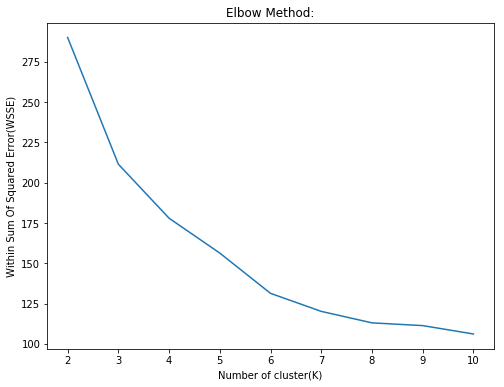

In [8]:
wsse = np.zeros(11)
for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = kmeans.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wsse[2:11])
ax.set_xlabel('Number of cluster(K)')
ax.set_ylabel('Within Sum Of Squared Error(WSSE)')
ax.set_title("Elbow Method:")

In [9]:
fig.savefig(base_path+"/plot/K-means_elbow_k=8")

### k = 8 from elbow method
### Train Model

In [10]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

for i in range(len(centers)):
    centers[i] = centers[i].tolist()
    centers[i] = ["Cluster "+str(i)] + centers[i]
# print("Cluster Centers: ")
# for center in centers:
#     print(center)
# type(centers)
transformed = model.transform(df_kmeans)
print(transformed.printSchema())
transformed = transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_k_means_k-8.csv", header=True)

root
 |-- LCLid: string (nullable = true)
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- prediction: integer (nullable = false)

None


In [11]:
cluster_centroid_rdd = sc.parallelize(centers)
cluster_centroid_rdd = cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
df_cluster_center=sqlcontext.createDataFrame(cluster_centroid_rdd,new_Feature_cols)
len(centers)

8

In [29]:
scaled_feature_list = [list(row) for row in df_kmeans.select("scaled_features").collect()]
scaled_feature_list = [[float(x) for x in list(row[0].values)] for row in scaled_feature_list]
avg_house_data = avg_house_data.drop("LCLid")
scaled_df = sc.parallelize(scaled_feature_list)
scaled_df = scaled_df.flatMap(lambda x : Row(x))
scaled_df = sqlcontext.createDataFrame(scaled_df,avg_house_data.schema)
scaled_df.printSchema()
type(scaled_feature_list[0][0])

root
 |-- 01: double (nullable = true)
 |-- 02: double (nullable = true)
 |-- 03: double (nullable = true)
 |-- 04: double (nullable = true)
 |-- 05: double (nullable = true)
 |-- 06: double (nullable = true)
 |-- 07: double (nullable = true)
 |-- 08: double (nullable = true)
 |-- 09: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)
 |-- 24: double (nullable = true)



float

If we don't assign color all plot will be of different color,
by putting ax=ax we are plotting on same graph,
if removed new graph below will be plotted.

Text(0, 0.5, 'Scaled average load profile (Kw/h)')

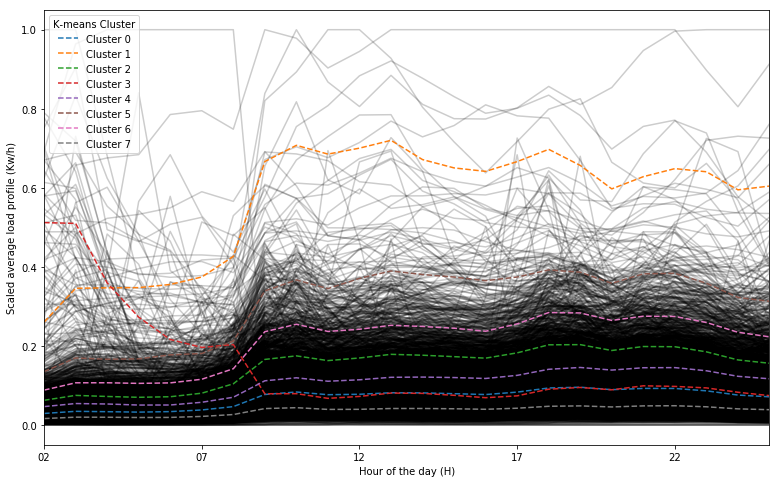

In [13]:
df_cluster_center = df_cluster_center.withColumnRenamed("01","K-means Cluster")
# ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.2)
plot = df_cluster_center.toPandas().set_index("K-means Cluster").T.plot(ax=ax,alpha=2,style='--')
ax.set_xlabel("Hour of the day (H)")
ax.set_ylabel("Scaled average load profile (Kw/h)")
# ax.set_title("K-menas Clu")

In [14]:
plot.get_figure().savefig(base_path+"/plot/cluster-8-means-scaled.png")

# Bisecting K-means

In [22]:
from pyspark.ml.clustering import BisectingKMeans

290.13105729803027
243.76570751782054
179.25781269372558
172.20790939475512
165.69306903279525
152.82831812092584
134.17368749518167
133.1516416899598
132.0803646089603


Text(0.5, 1.0, 'Elbow Method:')

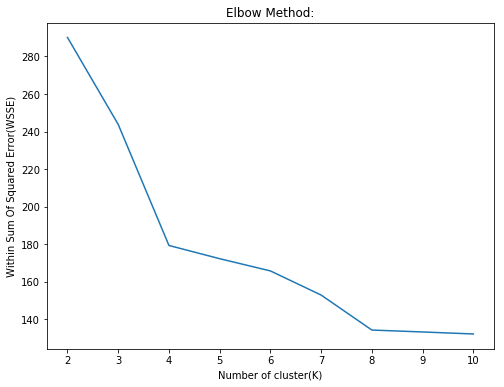

In [23]:
wsse = np.zeros(11)
for k in range(2,11):
    bkm = BisectingKMeans().setK(k).setSeed(5).setFeaturesCol("scaled_features")
    model = bkm.fit(df_kmeans)
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wsse[2:11])
ax.set_xlabel('Number of cluster(K)')
ax.set_ylabel('Within Sum Of Squared Error(WSSE)')
ax.set_title("Elbow Method:")

In [24]:
fig.savefig(base_path+"/plot/BK-means_elbow_k=8")

## k = 8 from elbow method

In [25]:
k = 8
bkm = BisectingKMeans().setK(8).setSeed(1).setFeaturesCol("scaled_features")
bkm_model = bkm.fit(df_kmeans)
bkm_cluster_center = bkm_model.clusterCenters()
bkm_transformed = bkm_model.transform(df_kmeans)
bkm_transformed = bkm_transformed.withColumnRenamed("prediction","cluster_id")
# transformed.select("cluster_id").show()
bkm_transformed.select("LCLid","cluster_id").toPandas().to_csv(base_path+"cluster_info_b-k_means_k-8.csv", header=True)

In [26]:
print(len(bkm_cluster_center))

8


In [27]:
for i in range(len(bkm_cluster_center)):
    bkm_cluster_center[i] = bkm_cluster_center[i].tolist()
    bkm_cluster_center[i] = ["Cluster "+str(i)] + bkm_cluster_center[i]
bkm_cluster_centroid_rdd = sc.parallelize(bkm_cluster_center)
bkm_cluster_centroid_rdd = bkm_cluster_centroid_rdd.flatMap(lambda x: Row(x))
# cluster_centroid_rdd.collect()
bkm_df_cluster_center=sqlcontext.createDataFrame(bkm_cluster_centroid_rdd,new_Feature_cols)

In [ ]:
bkm_df_cluster_center = bkm_df_cluster_center.withColumnRenamed("01","Bisecting K-means Cluster")
# ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
ax = scaled_df.toPandas().T.plot(figsize=(13,8), legend=False, color='black',alpha=0.2)
plot = bkm_df_cluster_center.toPandas().set_index("Bisecting K-means Cluster").T.plot(ax=ax,alpha=2,style='--')
ax.set_xlabel("Hour of the day (H)")
ax.set_ylabel("Scaled average load profile (Kw/h)")
# ax.set_title("K-menas Clu")

In [ ]:
plot.get_figure().savefig(base_path+"/plot/cluster-8bk-means-scaled.png")